In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

## Data Fetching

In [2]:
severity = pd.read_json("https://raw.githubusercontent.com/neherlab/covid19_scenarios/2a5d7fe2c1f4ff820a71f217531d2e2dfdca9a03/src/assets/data/severityData.json")
age_distribution = pd.read_json("https://raw.githubusercontent.com/neherlab/covid19_scenarios/2a5d7fe2c1f4ff820a71f217531d2e2dfdca9a03/src/assets/data/country_age_distribution.json")
region_summary = pd.read_json("https://raw.githubusercontent.com/neherlab/covid19_scenarios/2a5d7fe2c1f4ff820a71f217531d2e2dfdca9a03/src/assets/data/population.json")
region_summary = pd.concat([region_summary['name'], pd.json_normalize(region_summary['data'])], axis=1).set_index('name')

import urllib, json

response = urllib.request.urlopen('https://raw.githubusercontent.com/neherlab/covid19_scenarios/2a5d7fe2c1f4ff820a71f217531d2e2dfdca9a03/src/assets/data/case_counts.json')
case_counts = json.loads(response.read())


### Region selection

In [4]:
region = 'USA-New York'
# region = 'United States of America'
region_selection = region_summary.loc[region]
region_cases = pd.DataFrame(case_counts[region_selection.cases])
region_population = age_distribution[region_selection.country]

### Parameter specification

In [514]:
def lin_interp_df_from_dates(intervention_dict, index):
    data = []
    intervention_dates = sorted(intervention_dict.keys(), key=lambda x: pd.Timestamp(x))
    last_date = pd.Timestamp(intervention_dates[0])
    last_values = intervention_dict[intervention_dates[0]]
    for key in intervention_dates:
        values = intervention_dict[key]
        key_time = pd.Timestamp(key)
        interval = (key_time - last_date).days
        if interval == 0:
            continue
        data = data + [np.linspace(last_values, values, interval)]
        last_date = key_time
        last_values = values
    data = data + [
        np.ones(
            ((date_range[-1] - pd.Timestamp(last_date)).days + 1, len(last_values))
        ) * np.array(last_values)
    ]
    return pd.DataFrame(np.concatenate(data, axis=0), index=index)

def repeat_df_from_dates(intervention_dict, index):
    data = []
    last_date = index[-1]
    for key in sorted(intervention_dict.keys(), reverse=True):
        values = intervention_dict[key]
        key_time = pd.Timestamp(key)
        repeats = (last_date - key_time).days
        if not data:
            repeats = repeats +1
        data = [np.tile(values, (repeats, 1))] + data
        last_date = key_time
    return pd.DataFrame(np.concatenate(data, axis=0), index=index)

def population_sampler(demo, count):
    pop_samples = np.random.choice(range(len(demo)), count, p=demo)
    return np.bincount(pop_samples, minlength=len(demo))

def compartmental_pop_sampler(demo, compartmental_count):
    # NB: 
    matrix = np.zeros((len(demo), len(compartmental_count)))
    for index, compartment_count in compartmental_count.iteritems():
        matrix[:, index] = population_sampler(demo, compartment_count)
    return matrix.T

def gamma(mean, size=1, shape=3):
    return np.random.gamma(shape, mean/shape, size)

def rate_nb(kappa, p, shape_modifier=1, size=1):
    kappa_stochastic = gamma(kappa, size, 3/shape_modifier) # Default shape of 3 
    p_stochastic = gamma(p, size, 3/shape_modifier)
    return np.log(1+p_stochastic*kappa_stochastic)/kappa_stochastic


def beta_severity(mean, severity, size=1, baseline=10):
    # Severity modifies the distribution by multiplying raising the mean to a power of
    # sqrt(Severity)
    
    new_mean = np.power(mean, 1/np.sqrt(severity))
    b = baseline
    a = (b * new_mean) / (1 - new_mean)
    return np.random.beta(a, b, size)


def flux(d, pop):
    return np.minimum(np.round(pop * d), pop)

In [538]:
initial_state = pd.Series([region_selection.populationServed, 100, 50, 5, 0, 0 , 0, 0, 0, 0, 0], index=['S', 'E', 'P', 'V', 'Q', 'I', 'H', 'C', 'R', 'D', 'Con'])
initial_infection_dist = [.05,.1,.23,.24,.15,.12,.06,.03,.02]
# initial_infection_dist = [.1,.3,.3,.2,.1,0,0,0,0]
start_date = '03-05-2020'
date_range = pd.date_range(start_date, '01-01-2021')
p_tau = q_tau = .03
v_tau = i_tau = h_tau = .3

kappa = 100 # Arbitrarily chosen based on highly heterogenous network.

# param is time to transition 
e_mu = 3 # Despite stated mean to symptoms is 5.5 days, we assume lower because of included prodromal phase
p_mu = 3 
q_mu = 10
v_mu = 4 # We assume that the average person would move into isolation after 4 days with no mitigations present. Work culture factors in.
i_mu = 10 # We assume isolated people can still cause infections.
h_mu = 4 # People moving to the ICU and healthy people keep this low
c_mu = 14 


v_rho = 2/3
h_rho = 1/20
c_rho = 1/3
d_rho = 1/3


X = np.array([
    [.32, .1, .05, .2, .1, .04, .1, .07, .02],
    [.1, .3, .1, .1, .2, .1, .05, .04, .01],
    [.03, .1, .43, .15, .05, .12, .07, .03, .02],
    [.15, .05, .15, .33, .15, .05, .03, .03, .06],
    [.06, .17, .07, .11, .3, .11, .06, .07, .05],
    [.08, .07, .10, .07, .12, .25, .15, .10, .06],
    [.12, .09, .01, .15, .06, .1, .30, .1, .07],
    [.05, .1, .03, .05, .12, .05, .11, .34, .15],
    [.02, .06, .08, .02, .03, .11, .07, .22, .39]
]).T

Se = np.array([.25,.5, .5,.75,1,1.25,1.75,2.25,2.75])

# How well does the average physician protect themselves from infection compared to the rest of the population. PPE contingent.
m_hospital = repeat_df_from_dates({
    start_date: [.03,.03,.03,.03,.03,.03,.03,.03,.03],
    "03-17-20": [.1,.1,.1,.1,.1,.1,.1,.1,.1],
    "03-22-20": [.01,.01,.01,.01,.01,.01,.01,.01,.01]
}, date_range) 

# How well are people distancing - how big is their network relative to baseline
# It's possible that the shape of the variable should be inversely related to mean - some people will be irresponsible?
# TODO: Could use MTA ridership data for NYC as a way to compute this?
Contact = lin_interp_df_from_dates({
    start_date: [10,30,40,40,40,25,15,10,5],
    "03-09-20": [9, 18,30,30,30,20,12,8,4],
    "03-18-20": [6, 10,12,10,8, 8, 6, 6, 4],
    "03-22-20": [3, 3, 5, 5, 4, 3, 3, 3, 3],
    "03-25-20": [2, 2, 2, 2, 2, 2, 2, 2, 2],
    "05-01-20": [10,20,30,30,20,10,7,5,3] # HYPOTHETICAL relaxation of social distancing for all but elderly
}, date_range)

Contact_baseline = (Contact.loc[start_date].values*(region_population/region_population.sum())).sum()

# How good are people about hand washing, face touching.
m_sanitation = repeat_df_from_dates({
    start_date: [1,1,1,1,1,1,1,1,1],
    "03-20-20": [.8,.8,.8,.8,.8,.8,.8,.8,.8],
    "03-28-20": [.7,.6,.5,.5,.5,.5,.5,.5,.5],
    "04-05-20": [.5,.4,.3,.3,.3,.3,.3,.3,.3] # HYPOTHETICAL mask distribution, training on not touching faces
}, date_range)

# How long compared to the average time does someone take to isolate when they have symptoms
m_isolation_awareness = repeat_df_from_dates({
    start_date: [1,1,1,1,1,1,1,1,1],
    "03-21-20": [.8,.8,.8,.8,.8,.8,.8,.8,.8],
    "03-26-20": [.5,.5,.5,.5,.5,.5,.5,.5,.5]
}, date_range) 

# How much contact does someone isolating have. 
# Isolators likely still live in households, so it is still integral as opposed to fractional.
m_isolation_effectiveness = repeat_df_from_dates({
    start_date: [5,5,5,5,5,5,4,3,2],
    "03-21-20": [2,2,2,2,2,2,2,2,2]
}, date_range)

# Increasing the threshold for hospitalization/testing (rest go to isolation).
inpatient_refusal = repeat_df_from_dates({
    start_date: [1,1,1,1,1,1,1,1,1],
    "03-26-20": [.5,.5,.5,.5,.5,.5,.5,.5,.5]
}, date_range)


# NB: The following are state based, as opposed to demography based
# ['S', 'E', 'P', 'V', 'Q', 'I', 'H', 'C', 'R', 'D', 'Con']
imports = repeat_df_from_dates({
    start_date: [0, 10, 5, 2, 10, 10, 0, 0, 0, 0, 0],
    "03-15-20": [0, 10, 5, 2, 5, 5, 0, 0, 0, 0, 0],
    "03-22-20": [0, 5, 2, 1, 2, 1, 0, 0, 0, 0, 0]
}, date_range) # TODO make this interact with other models as a flux? For now, the 

In [539]:
def initialize_population(N: int, date_range: pd.DatetimeIndex, ages: pd.Index, demo: pd.Series, initial_infection_dist: list = [], likely: pd.Series = pd.Series(0, index=['S', 'E', 'P', 'V', 'Q', 'I', 'H', 'C', 'R', 'D', 'Con']), percent_resistant: int = 0):
    ind = pd.MultiIndex.from_product([date_range, ['S', 'E', 'P', 'V', 'Q', 'I', 'H', 'C', 'R', 'D', 'Con']], names=['date', 'state'])
    df = pd.DataFrame(0, columns=ages, index=ind)
    
    if not initial_infection_dist:
        initial_infection_dist = demo
    
    likely['R'] = np.floor(percent_resistant * N).astype(int)
    if likely['R'] > 0:
        df.loc[date_range[0], 'R'] = population_sampler(initial_infection_dist, np.floor(percent_resistant * N).astype(int))
    
    removed_from_S = likely.sum() - (likely['S'] + likely['R'])
    initial_S = population_sampler(demo, np.floor((N - removed_from_S)).astype(int))
    df.loc[date_range[0], 'S'] = initial_S
    
    for col in likely.index:
        if col == 'S' or col == 'R' or col == 'Con':
            continue
        if likely[col] > 0:
            df.loc[date_range[0], col] = population_sampler(initial_infection_dist, likely[col])
    
    df.loc[date_range[0], 'Con'] = df.loc[date_range[0], 'H']
    return df

In [540]:
# TODO: Move everything to matrix based calculations opposed to separate operations. Move away from pandas.
# Variable sampling should likely be done as a separate step from matrix mult.

def compute_next(population: pd.DataFrame, date: str):
    date = pd.Timestamp(date)
    previous_date = date - pd.Timedelta(days=1)
    S_old, E_old, P_old, V_old, Q_old, I_old, H_old, C_old, R_old, D_old, Con_old = population.loc[previous_date].values
    L_pop = population.loc[previous_date].sum() - D_old - Con_old
    s = len(S_old) # Demographic dimensions
    
    non_isolating_contact = (
        p_tau * P_old +
        v_tau * V_old +
        h_tau * H_old * m_hospital.loc[previous_date]
    ) * Contact.loc[previous_date]
    
    isolating_contact = i_tau * I_old / m_isolation_effectiveness.loc[previous_date]
    
    r = np.matmul(
        (non_isolating_contact + isolating_contact) * m_sanitation.loc[previous_date]  / L_pop.values,
        X
    )
    # NB/TODO: distancing is modeling as influencing shape, not just mean. Some people are stubborn, tailedness should change. 
    # This could be a separate mitigation param, as things like restricting public events could change the tailed-ness, mixing. 
    flux_in_exposed = flux(
        rate_nb(kappa, r, Contact.loc[previous_date].mean() / Contact_baseline, s),
        S_old
    )
    flux_in_prodromal = flux(gamma(e_mu, s), E_old)
    flux_out_prodromal = flux(gamma(p_mu, s), P_old)
    flux_in_virulent = flux(beta_severity(v_rho, Se, s), flux_out_prodromal)
    flux_in_subclinical = flux_out_prodromal - flux_in_virulent
    flux_out_subclinical = flux(gamma(q_mu, s), Q_old)
    flux_out_virulent =  flux(gamma(v_mu * m_isolation_awareness.loc[previous_date], s), V_old)
    flux_out_virulent_hospitalized = flux(beta_severity(h_rho*inpatient_refusal.loc[previous_date], Se, s), flux_out_virulent)
    flux_out_virulent_isolated = flux_out_virulent - flux_out_virulent_hospitalized
    flux_out_isolated = flux(gamma(i_mu, s), I_old)
    flux_out_hospitalized = flux(gamma(h_mu/Se, s), H_old) 
    flux_in_critical = flux(beta_severity(c_rho, Se, s), flux_out_hospitalized)
    flux_out_hospitalized_recovered = flux_out_hospitalized - flux_in_critical
    flux_out_critical = flux(gamma(c_mu, s), C_old)
    flux_in_dead = flux(beta_severity(d_rho, Se, s), flux_out_critical)
    flux_out_critical_recovered = flux_out_critical - flux_in_dead
    
    S = S_old - flux_in_exposed
    E = E_old + flux_in_exposed - flux_in_prodromal
    P = P_old + flux_in_prodromal - flux_out_prodromal
    V = V_old + flux_in_virulent - flux_out_virulent_hospitalized - flux_out_virulent_isolated
    Q = Q_old + flux_in_subclinical - flux_out_subclinical
    I = I_old + flux_out_subclinical + flux_out_virulent_isolated - flux_out_isolated
    H = H_old + flux_out_virulent_hospitalized - flux_out_hospitalized
    C = C_old + flux_in_critical - flux_out_critical
    R = R_old + flux_out_isolated + flux_out_hospitalized_recovered + flux_out_critical_recovered
    D = D_old + flux_in_dead
    
    # TODO: Make confirmations influence state transition to isolation? Also make testing parameterized in time.
    Con = Con_old + flux_out_virulent_hospitalized + np.floor(flux_out_virulent_isolated / 4) + np.floor(flux_in_subclinical / 20)
    
    import_flux = compartmental_pop_sampler(region_population/region_population.sum(), imports.loc[previous_date])
    #Maintain constant population, though a realistic simulation would include outflow from impacted areas
    S = S - np.sum(import_flux).astype(int)
    population.loc[date] = np.array([S, E, P, V, Q, I, H, C, R, D, Con]) + import_flux
    

In [541]:
%%time
# Use NYC population, not state
pop = initialize_population(
    8.9E6, date_range, 
    ages=region_population.index, 
    demo=region_population/region_population.sum(), 
    likely=initial_state,
    initial_infection_dist=initial_infection_dist
)

CPU times: user 348 ms, sys: 21.4 ms, total: 369 ms
Wall time: 370 ms


In [542]:
%%time
for date in date_range[1:]:
    compute_next(pop, date)

CPU times: user 1.55 s, sys: 8.4 ms, total: 1.56 s
Wall time: 1.56 s


In [543]:
pop.loc['2020-03-27']

0-9      10-19      20-29      30-39      40-49  \
date       state                                                          
2020-03-27 S      1045503.0  1112520.0  1198438.0  1168614.0  1063277.0   
           E          653.0      821.0      911.0      817.0      475.0   
           P          767.0      884.0      917.0      930.0      851.0   
           V          366.0     1485.0      882.0     1207.0      614.0   
           Q          640.0      456.0      384.0      485.0      250.0   
           I         1282.0      295.0     2262.0     1434.0     1059.0   
           H            0.0        0.0        0.0        0.0        3.0   
           C            1.0        0.0        0.0        1.0       58.0   
           R        18518.0    21267.0    33464.0    27636.0    17437.0   
           D            2.0        2.0        5.0       34.0       49.0   
           Con       2934.0     3842.0     5827.0     5589.0     3984.0   

                      50-59      60-69     70-79       80+  
date       state                                            
2020-03-27 S      1105327.0  1016410.0  634265.0  346150.0  
           E          637.0      574.0     360.0     167.0  
           P          955.0      646.0     548.0     180.0  
           V          708.0      698.0     357.0     192.0  
           Q          370.0      211.0      84.0      63.0  
           I         1171.0     1158.0     676.0     471.0  
           H            0.0      183.0      72.0      12.0  
           C            4.0       25.0     181.0       4.0  
           R        22272.0    15363.0   10659.0    5207.0  
           D          176.0      168.0     197.0     231.0  
           Con       5162.0     4174.0    3252.0    1924.0

In [544]:
non_demo = pop.sum(axis=1).unstack()

In [545]:
non_demo = non_demo.assign(A=non_demo.loc[:,['P', 'I', 'V', 'H', 'C', 'Q', 'R']].sum(axis=1))

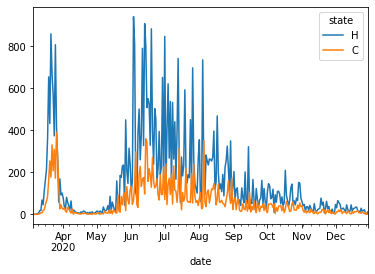

In [546]:
non_demo.loc[:'12-30-20',['H', 'C']].plot()

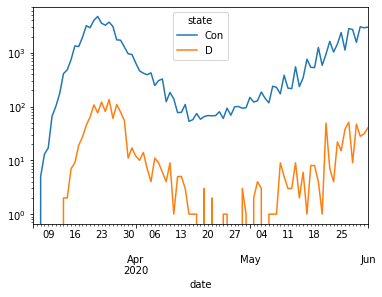

In [557]:
# Daily confirms, deaths.
pop.loc[:'06-01-20'].sum(axis=1).unstack()[['Con', 'D']].diff().plot(logy=True)

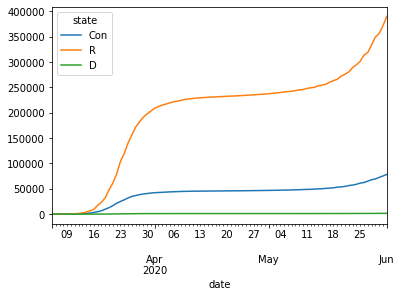

In [552]:
pop.loc[:'06-01-20'].sum(axis=1).unstack()[['Con', 'R', 'D']].plot()